In [ ]:
# Import Necessary Libraries
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization

print("Loaded all libraries")

Loaded all libraries


In [ ]:
# Download and Unrar dataset files, Skip this if you already have the dataset downloaded and extracted
!gdown --id 1-jkPhru6HdLI9FFMHQO2LP9-wbLYQ-N5
!unrar x "Collated-3.rar" "Collated/"

Streaming output truncated to the last 5000 lines.
Extracting  Collated/Collated/O/O_7.jpg                                   54%  OK 
Extracting  Collated/Collated/O/O_70.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_71.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_72.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_73.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_74 (2).jpg                              54%  OK 
Extracting  Collated/Collated/O/O_74.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_75.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_76.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_77.jpg                                  54%  OK 
Extracting  Collated/Collated

In [ ]:
#########################################

In [ ]:
# Define helper functions

# Convert folder to dataframe of images' paths & labels
def get_paths_labels(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)

        filepaths = pd.Series((images_dir.glob(fr'**/*.jpg'))).astype(str)
        filepaths.name = "path"

        labels = filepaths.str.split("/")[:].str[-2]
        labels.name = "label"

        # Concatenate filepaths and labels
        df = pd.concat([filepaths, labels], axis=1)

        # Shuffle the DataFrame and reset index
        df = df.sample(frac=1).reset_index(drop = True)
        return df

In [ ]:
# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    print("classes", classes)
    labels = classes[np.array(datagen.labels)[random_indexes]]
    print("labels", labels)
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)

    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()

In [ ]:
# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]

    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])

    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels

    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)

    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

In [ ]:
from pathlib import Path
import os.path
import pandas as pd

train_df = get_paths_labels('Collated/')

dataset = train_df

In [ ]:
# Classes counts
print("Classes counts")
counts = dataset.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
A    450
B    450
C    450
D    450
E    450
F    450
G    450
H    450
I    450
J    450
K    450
L    450
M    450
N    450
O    450
P    450
Q    450
R    450
S    450
T    450
U    450
V    450
W    450
X    450
Y    450
Z    450
Name: label, dtype: int64


Dataset size = 11700 samples


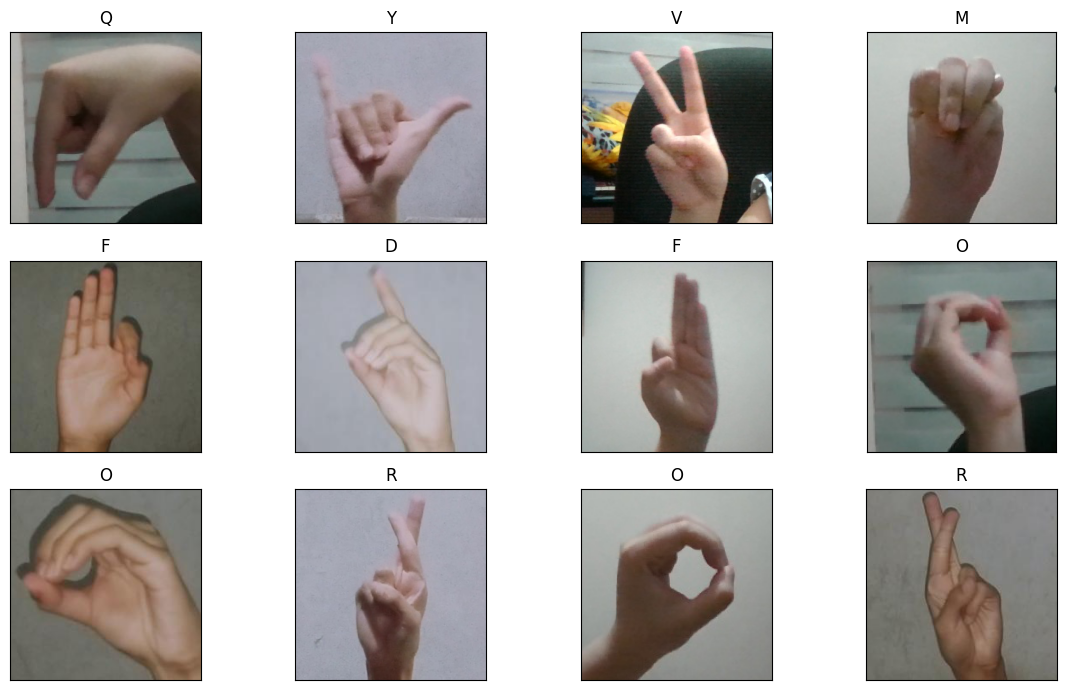

In [ ]:
# Visualize Dataset

fig, axes = plt.subplots(3, 4, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataset.path[idx]))
    ax.set_title(dataset.label[idx])
plt.tight_layout()
plt.show()

In [ ]:
dataset.std()

<ipython-input-21-d926424df4d9>:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.std()


Series([], dtype: float64)

In [ ]:
df_train, df_test = train_test_split(dataset, test_size=0.1, random_state=42)

In [ ]:
print('Training size: {} images\nTest size: {} images'.format(len(df_train), len(df_test)))


Training size: 10530 images
Test size: 1170 images


In [ ]:
import cv2
import numpy as np
def preprocessing_fun(filename):
    img = cv2.imread(filename)
    dst = dst/255.0
    return dst


In [ ]:
# Generators

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2 # 20% of the training data will be used for validation
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
BATCH_SIZE = 32
train_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 8424 validated image filenames belonging to 26 classes.
Found 2106 validated image filenames belonging to 26 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1170 validated image filenames belonging to 26 classes.


In [ ]:
#########################################

In [ ]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(224,224,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(224,224,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(26,activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 26, 26, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                      

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
final = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50, # since we are running on CPU, we keep the number of epoch low
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping( # we apply earlystopping to prevent overfitting
    #         monitor='val_loss',
    #         patience=3, # we choose patience=3 to stop the model fit if val_loss won't decrease for 3 epoch
    #         restore_best_weights=True # choose the best weights when early-stopping
    #     )
    # ]
)

Epoch 1/50
264/264 [==============================] - 36s 115ms/step - loss: 2.7378 - accuracy: 0.2485 - val_loss: 3.4243 - val_accuracy: 0.0874
Epoch 2/50
264/264 [==============================] - 34s 128ms/step - loss: 1.0974 - accuracy: 0.6489 - val_loss: 1.3978 - val_accuracy: 0.5632
Epoch 3/50
264/264 [==============================] - 28s 106ms/step - loss: 0.5083 - accuracy: 0.8329 - val_loss: 0.8804 - val_accuracy: 0.7540
Epoch 4/50
264/264 [==============================] - 28s 106ms/step - loss: 0.2629 - accuracy: 0.9143 - val_loss: 0.3780 - val_accuracy: 0.8837
Epoch 5/50
264/264 [==============================] - 28s 107ms/step - loss: 0.1661 - accuracy: 0.9480 - val_loss: 3.7867 - val_accuracy: 0.3300
Epoch 6/50
264/264 [==============================] - 64s 242ms/step - loss: 0.1601 - accuracy: 0.9491 - val_loss: 0.2175 - val_accuracy: 0.9354
Epoch 7/50
264/264 [==============================] - 29s 109ms/step - loss: 0.1028 - accuracy: 0.9663 - val_loss: 0.2926 - val_ac

In [ ]:
results = model.evaluate(test_images)


37/37 [==============================] - 3s 69ms/step - loss: 0.0305 - accuracy: 0.9915


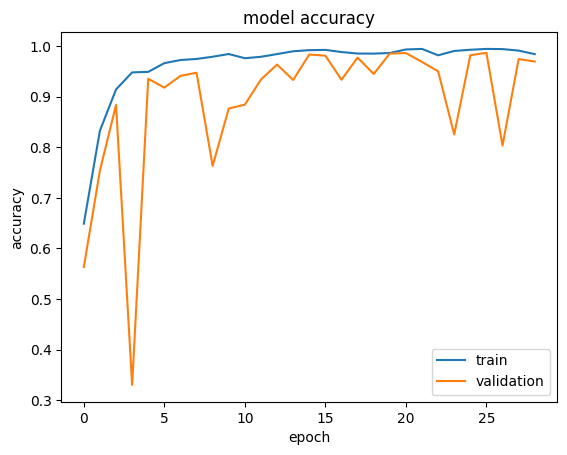

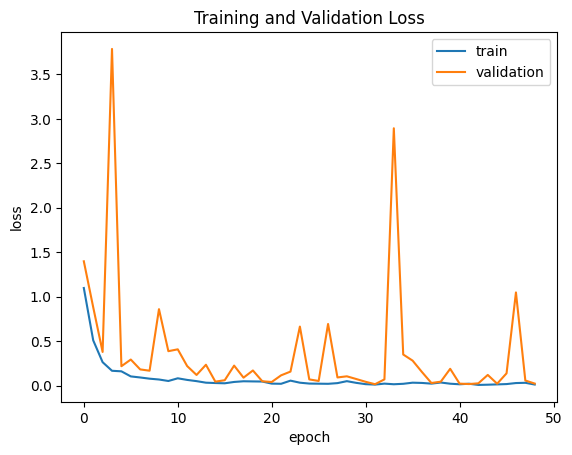

In [ ]:
# # Plot training and validation accuracy
plt.plot(final.history['accuracy'][1:30])
plt.plot(final.history['val_accuracy'][1:30])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
# plt.ylim((0.9,1)) # limit y-axis to 90-100% accuracy
plt.show()

# Plot training and validation loss
plt.plot(final.history['loss'][1:])
plt.plot(final.history['val_loss'][1:])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
print('Training Accuracy: {:.2f}%'.format(final.history["accuracy"][-1:][0]*100))
print('Validation Accuracy: {:.2f}%'.format(final.history["val_accuracy"][-1:][0]*100))
print('Testing Accuracy: {:.2f}%'.format(results[1]*100))

Training Accuracy: 99.70%
Validation Accuracy: 99.57%
Testing Accuracy: 99.15%


In [ ]:
print('Training Loss: {:.3f}'.format(final.history["loss"][-1:][0]))
print('Validation Loss: {:.3f}'.format(final.history["val_loss"][-1:][0]))
print('Testing Loss: {:.3f}'.format(results[0]))

Training Loss: 0.011
Validation Loss: 0.022
Testing Loss: 0.030


In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels_1 = (train_images.class_indices)
labels = {y:x for x, y in labels_1.items()}
pred = [labels[idx] for idx in pred] # create a list of the predicted labels


37/37 [==============================] - 3s 66ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

y_test = list(df_test.label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        37
           B       1.00      0.97      0.99        39
           C       1.00      0.98      0.99        54
           D       1.00      0.98      0.99        46
           E       1.00      1.00      1.00        52
           F       1.00      0.98      0.99        44
           G       1.00      1.00      1.00        51
           H       1.00      1.00      1.00        37
           I       1.00      1.00      1.00        43
           J       1.00      0.98      0.99        53
           K       1.00      1.00      1.00        39
           L       1.00      1.00      1.00        43
           M       0.93      1.00      0.96        39
           N       1.00      1.00      1.00        52
           O       1.00      1.00      1.00        36
           P       1.00      0.98      0.99        45
           Q       0.92      0.98      0.95        50
           R       1.00    

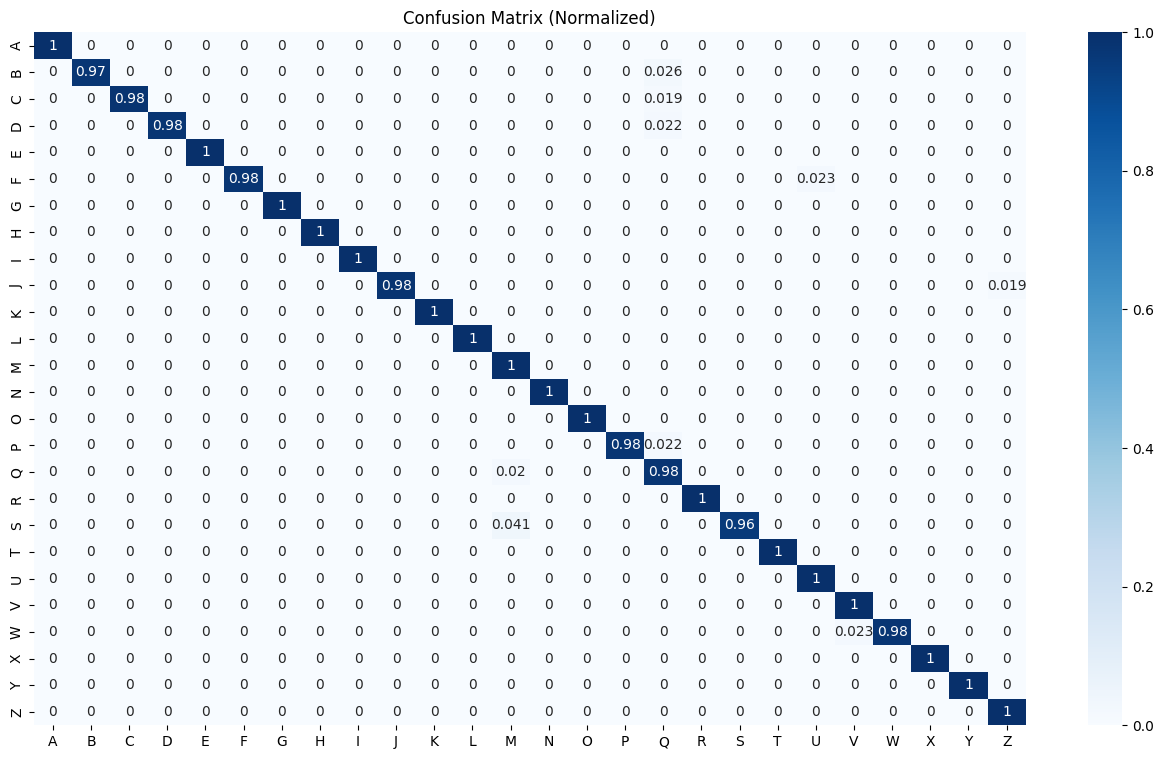

In [ ]:
conf_matrix = confusion_matrix(y_test, pred, normalize = 'true')
plt.figure(figsize = (16,9))
sns.heatmap(conf_matrix, cmap='Blues',annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
!pip install onnx==1.12
!pip install tf2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery 3.9.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery-storage 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.1 which is incompatible.


In [ ]:
# Save models and graphs

final.model.save("Comp/alexnet_model_final_224.h5")
!mkdir -p saved_model
final.model.save('saved_model_224/my_model_224')
np.save('history_alexnet_224.npy',final.history)
!zip -r saved_model_224.zip saved_model_224

  adding: saved_model_224/ (stored 0%)
  adding: saved_model_224/my_model_224/ (stored 0%)
  adding: saved_model_224/my_model_224/saved_model.pb (deflated 89%)
  adding: saved_model_224/my_model_224/assets/ (stored 0%)
  adding: saved_model_224/my_model_224/keras_metadata.pb (deflated 94%)
  adding: saved_model_224/my_model_224/variables/ (stored 0%)
  adding: saved_model_224/my_model_224/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model_224/my_model_224/variables/variables.index (deflated 71%)
  adding: saved_model_224/my_model_224/fingerprint.pb (stored 0%)


In [ ]:
from google.colab import files
files.download("saved_model.zip")
files.download("Comp/alexnet_model_final.h5")
files.download("history_alexnet.npy")

FileNotFoundError: ignored

In [ ]:
# Model Conversion to ONNX

!python -m tf2onnx.convert --saved-model saved_model_224/my_model_224 --output saved_model-alexnet_224.onnx
# files.download("saved_model-alexnet_224.onnx")


2023-06-16 09:19:46.839595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-06-16 09:19:51.953010: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-16 09:19:51,957 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-06-16 09:19:54.008483: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-06-16 09:19:54.080505: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16384000 exceeds 10% of free system memory.
2023-06-16 09:19:54.138412: W tensorflow/tsl/fram

In [ ]:
#### If GDRIVE Download is too slow: Execute the following lines instead to transfer the files directly to your drive ####

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp -av "/content/saved_model_224.zip" "/content/drive/MyDrive/199/Models/Alexnet/2/"


'/content/saved_model_224.zip' -> '/content/drive/MyDrive/199/Models/Alexnet/2/saved_model_224.zip'


In [ ]:
%cp -av "/content/Comp/alexnet_model_final_224.h5" "/content/drive/MyDrive/199/Models/Alexnet/2/"
%cp -av "/content/saved_model-alexnet_224.onnx" "/content/drive/MyDrive/199/Models/Alexnet/2/"
%cp -av "/content/history_alexnet_224.npy" "/content/drive/MyDrive/199/Models/Alexnet/2/"


'/content/Comp/alexnet_model_final_224.h5' -> '/content/drive/MyDrive/199/Models/Alexnet/2/alexnet_model_final_224.h5'
'/content/saved_model-alexnet_224.onnx' -> '/content/drive/MyDrive/199/Models/Alexnet/2/saved_model-alexnet_224.onnx'
'/content/history_alexnet_224.npy' -> '/content/drive/MyDrive/199/Models/Alexnet/2/history_alexnet_224.npy'


In [ ]:
# from :  https://www.kaggle.com/code/msripooja/dog-images-classification-using-keras-alexnet#1